In [15]:
import numpy as np
import pandas as pd
import math
import csv
import os
import time
import matplotlib as mpl
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import writers

%matplotlib notebook

In [16]:
def normalize(x):
    max= 0.0
    for i in range(len(x)):
        if abs(x[i]) > max:
            max = abs(x[i])
    for i in range(len(x)):
        x[i] /= max
    return x

In [17]:
def spectrum(Vib_Freq, observable, fwhm, num_points, spectro):
    max_freq = 0.49593677
    min_freq = 0
    delta = float((max_freq-min_freq)/num_points)
    Vib_Freq_axis  = np.arange(min_freq, max_freq, delta)
    Vib_Freq_axis_cm1 = np.zeros(len(Vib_Freq_axis))
    spec = [0]*len(Vib_Freq_axis)
    if spectro == 'ROA':
        peak_pos = peak_finder(observable, Vib_Freq)
        for i in range(len(Vib_Freq_axis)):
            for j in range(len(peak_pos)):
                spec[i] += observable[j]/(1+(2*(Vib_Freq_axis[i]-peak_pos[j])/fwhm)**2)
            Vib_Freq_axis_cm1[i] = Vib_Freq_axis[i]*8065.54429
    else:
        for i in range(len(Vib_Freq_axis)):
            for j in range(len(Vib_Freq)):
                spec[i] += (1/((2.296*10**(-39))*math.sqrt(np.pi)*fwhm))*Vib_Freq[j]*observable[j]*np.exp(-((Vib_Freq_axis[i]-Vib_Freq[j])/fwhm)**2)
            Vib_Freq_axis_cm1[i] = Vib_Freq_axis[i]*8065.54429
    return spec, Vib_Freq_axis_cm1

In [18]:
def peak_finder(CID3, Vib_Freq):
    peak_pos = []
    ind_max = argrelextrema(CID3, np.greater)
    #print(ind_max)
    for i in range(len(ind_max[0])):
        peak_pos.append(Vib_Freq[ind_max[0][i]])
    return peak_pos

In [5]:
def sorting(CID3, Vib_Freq):
    #combine the arrays using np.column_stack()
    combined = np.column_stack((Vib_Freq, CID3))
    #sort the combined array based on the fisrt column
    sorted_combined = combined[combined[:,0].argsort()]
    #unpack the sorted array into separate arrays
    Vib_Freq3_sorted = sorted_combined[:,0]
    CID33_sorted = sorted_combined[:,1]
    return Vib_Freq3_sorted, CID33_sorted

In [20]:
# fully converged spectrum

spectro = input("Enter the spectroscopy method used : ")
t1 = time.time()
with open("Sorted.txt","r") as f:
    content = f.readlines()
    data = np.zeros((len(content), 4))
    for i, line in enumerate(content):
        data[i] = line.split()
        
cmpd = data[:,0].astype(int)
GFE = data[:,1].astype(float)
Vib_Freq = data[:,2].astype(float)
observable = data[:,3].astype(float)

with open("Combined_Free_Energy.txt","r") as f:
    content = f.readlines()
    data = np.zeros((len(content), 2))
    for i, line in enumerate(content):
        data[i] = line.split()
        
cmpd2 = data[:,0].astype(int)
GFE2 = data[:,1].astype(float)

num_points = 2000
fwhm = 0.008

ROA_conv, Vib_Freq_axis_conv = spectrum(Vib_Freq, observable, fwhm, num_points, spectro)

t2 = time.time()
print(t2-t1)        

Enter the spectroscopy method used : ROA
122.0941686630249


In [22]:
# snapshot averaged spectrum
t1 = time.time()

X = []
Y = []

snaps = []

#read the data from the file into a pandas dataframe
data = pd.read_csv("Sorted_rs.txt", delim_whitespace=True, header=None, usecols=[0, 2, 3], names=["cmpd_rs", "Vib_Freq_rs", "CID3_rs"])

# Count the occurrences of each value in the "cmpd_rs" column
ctr = np.bincount(data["cmpd_rs"])
ctr = ctr[1:]

# set params
num_points = 2000
fwhm = 0.008
tot_snapshots = len(cmpd2)
step_size = 50
beg_list = []
end_list = []

#loop over snapshots
beg = 0
for snap in range(step_size, tot_snapshots+1, step_size):
    beg_list.append(beg)
    print("Collecting data for snapshots till : ", snap)
    end = np.sum(ctr[:snap])
    snaps.append(snap)
    if snap == step_size:
        cmpd3 = data["cmpd_rs"].values[beg:end]
        Vib_Freq3 = data["Vib_Freq_rs"].values[beg:end]
        observable3 = data["CID3_rs"].values[beg:end]
    else:
        cmpd3 = np.concatenate((cmpd3, data["cmpd_rs"].values[beg:end]))
        Vib_Freq3 = np.concatenate((Vib_Freq3, data["Vib_Freq_rs"].values[beg:end]))
        observable3 = np.concatenate((observable3, data["CID3_rs"].values[beg:end]))
        
    #sort the data by Vib_Freq3
    Vib_Freq3_sorted, observable3_sorted = sorting(observable3, Vib_Freq3)
    #if snap==100:
     #   if not (peak_pos == peak_pos3):
      #      for i, (x, y) in enumerate(zip(peak_pos, peak_pos3)):
       #         if x != y:
        #            del peak_pos3[i]
    spec,freq = spectrum(Vib_Freq3_sorted, observable3_sorted, fwhm, num_points, spectro)
    X.append(freq)
    Y.append(spec)
    
    end_list.append(end)
    beg = end
t2 = time.time()
print(t2-t1)

1363.1755187511444


<IPython.core.display.Javascript object>


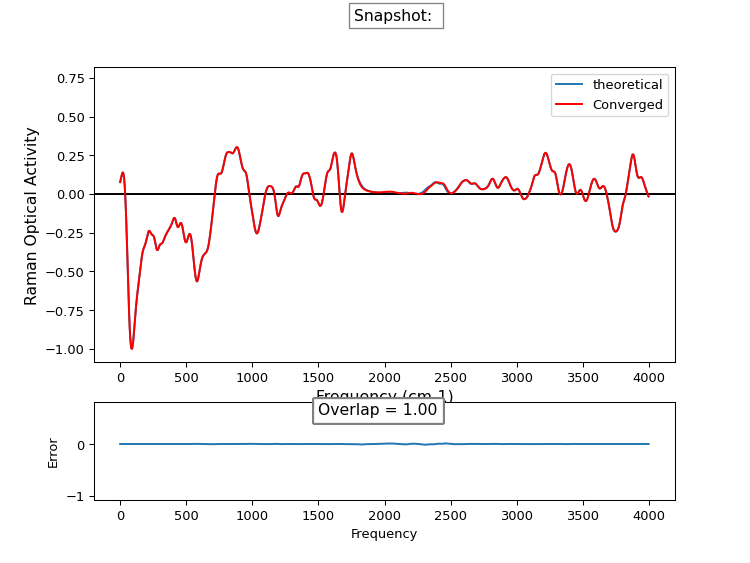

In [23]:
# Create the figure and axes
plt.rcParams["figure.figsize"] = [8,6]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
#axs = fig.add_subplot(111)
line1, = ax1.plot(X[0], normalize(Y[0]), label="theoretical")
freq_exp = np.array(Vib_Freq_axis_conv)
spec_exp = np.array(normalize(ROA_conv))
line2, = ax2.plot(X[0], normalize(Y[0]), label="Error")
#ax1.set_xlim(210,2500)
#ax2.set_xlim(210,2500)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Error')

ax1.set_xlabel('Frequency (cm-1)', fontsize=12)
ax1.set_ylabel('Raman Optical Activity', fontsize=12)
ax1.axhline(y = 0, color = 'black')
snapshot = ax1.text(2400, 1.2, '', ha='right', va='top', fontsize=12,bbox=dict(facecolor='white', edgecolor='gray'))

# Define the number of frames to be the length of E
num_frames = len(Y)
ax1.plot(Vib_Freq_axis_conv, ROA_conv, color="red", label="Converged")
ax1.legend()



overlap_list = []
# Define the animation function to update the y-data of line0 and snapshot
def animate(i):
    line1.set_ydata(normalize(Y[i]))
    line1.set_xdata(X[i])

    freq_theory = np.array(X[i])
    spec_theory = np.array(normalize(Y[i]))
    error = spec_exp - spec_theory
    # Calculate the overlap
    overlap = np.trapz(spec_exp*spec_theory, freq_exp)
    deno1 = np.trapz(spec_exp*spec_exp, freq_exp)
    deno2 = np.trapz(spec_theory*spec_theory, freq_exp)
    deno = np.sqrt(deno1*deno2)
    overlap /= deno
    
    overlap_list.append(overlap)
    flag = (i+1)*5
    snapshot.set_text('Snapshot: ')
    # Plot the error spectrum on the lower axes
    line2.set_ydata(error)
    line2.set_xdata(freq_exp)
    #line2 = ax2.plot(freq_exp, error, label='Error')
    # Plot the overlap as a text box
    ax2.text(2400, 0.8, 'Overlap = %.2f' % overlap, ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='gray'))
    area = np.trapz(error, x=freq_exp)

    # Add the shaded area to the error plot
    #ax2.fill_between(freq_exp, error, alpha=0.2, color='blue')
    
    #ax2.set_xlim(2200,3000)
    #ax2.legend()
    return line1,line2,snapshot
    

# Plotting dynamic spectrum
ani = anim.FuncAnimation(
    fig, animate, frames=num_frames, interval=1000,repeat=False)

plt.show()

In [24]:
overlap_list

[0.38387620707240766,
 0.38387620707240766,
 0.6266022177275006,
 0.4952292928924868,
 0.48047304608803826,
 0.6499982740564123,
 0.6434706810492256,
 0.622413725671018,
 0.5978980680790824,
 0.637663634673059,
 0.6607581039625993,
 0.7280180850592226,
 0.8123567471998513,
 0.8450401350642904,
 0.8369627685847271,
 0.8957657017144346,
 0.9165048782225781,
 0.9424469991640103,
 0.9625271054573358,
 0.9787421618690518,
 0.9998945946333082]

In [10]:
len(peak_pos)

NameError: name 'peak_pos' is not defined

In [10]:
np.sum(observable == observable3_sorted)

213352

In [11]:
len(observable)

214492

In [12]:
len(Vib_Freq)

214492

In [13]:
np.sum(Vib_Freq == Vib_Freq3_sorted)

214492

In [15]:
list1 = observable
list2 = observable3_sorted

for i, (x, y) in enumerate(zip(list1, list2)):
    if x != y:
        print(f"Lists differ at index {i}: {x} != {y}")
        continue
else:
    print("Lists are identical")

Lists differ at index 1644: 149240.0 != -499420.0
Lists differ at index 1645: -499420.0 != 149240.0
Lists differ at index 2209: -551370.0 != 513750.0
Lists differ at index 2210: 513750.0 != -551370.0
Lists differ at index 2656: 47920.0 != -255650.0
Lists differ at index 2657: -255650.0 != 47920.0
Lists differ at index 3044: -529810.0 != 609130.0
Lists differ at index 3045: 609130.0 != -529810.0
Lists differ at index 3323: 1019720.0 != 4110.0
Lists differ at index 3324: 4110.0 != 1019720.0
Lists differ at index 3382: -294930.0 != 483950.0
Lists differ at index 3383: 483950.0 != -294930.0
Lists differ at index 3638: -433770.0 != 288200.0
Lists differ at index 3639: 288200.0 != -433770.0
Lists differ at index 3670: -354370.0 != -1117660.0
Lists differ at index 3671: -1117660.0 != -354370.0
Lists differ at index 3710: 148130.0 != 245270.0
Lists differ at index 3711: 245270.0 != 148130.0
Lists differ at index 4093: 1009140.0 != -299950.0
Lists differ at index 4094: -299950.0 != 1009140.0
Li